# 🎓 Machine Learning for Education Data with SAP HANA PAL

## Welcome to Your ML Journey!

This notebook will teach you how to use **SAP HANA's Predictive Analysis Library (PAL)** to build machine learning models for education data. Don't worry if you're not a statistics expert - we'll explain everything step by step!

### What You'll Learn:

1. **🎯 Dropout Prediction** - Which municipalities are at risk?
2. **📊 Municipality Clustering** - How to group similar regions?
3. **🔍 Anomaly Detection** - How to spot unusual patterns?
4. **📈 Feature Importance** - What factors matter most?

### What is Machine Learning?

Think of machine learning as teaching a computer to recognize patterns, just like you learned to recognize patterns as a child:
- You learned "hot stove = danger" without touching every stove
- You can predict "dark clouds = probably rain" from experience
- You group similar items together ("all dogs bark, all cats meow")

Machine learning does the same with data!

### Why Use SAP HANA PAL?

**PAL (Predictive Analysis Library)** runs machine learning **inside** the database:
- ⚡ **Faster**: No need to move data around
- 🔒 **Secure**: Data stays in HANA
- 💪 **Powerful**: Handles big datasets easily
- 🎯 **Production-Ready**: Enterprise-grade algorithms

Let's get started! 🚀

---

## 📋 Table of Contents

1. [Setup & Connection](#setup)
2. [Load Existing Data from HANA](#load-data)
3. [Exploratory Data Analysis](#eda)
4. [Dropout Prediction with Random Forest](#random-forest)
5. [Municipality Clustering with K-Means](#kmeans)
6. [Anomaly Detection with Isolation Forest](#anomaly)
7. [Insights & Recommendations](#insights)

---

<a id='setup'></a>
## 1. Setup & Connection

### What We're Doing:
Before we can analyze data or build models, we need to:
1. Import the necessary Python libraries
2. Connect to SAP HANA Cloud
3. Read existing data from HANA (uploaded in previous notebook)

### Why HANA Connection?
We're using **hana-ml**, SAP's Python library that lets us:
- Read data from HANA tables
- Run PAL algorithms in HANA (not in Python!)
- Get results back to Python for visualization

Think of it like ordering food: You tell the restaurant (HANA) what you want, they cook it (run the algorithm), and deliver it back to you (results).

### 📝 Note on Data:
We're **not re-uploading** the data. Instead, we'll read from the `EDU_FEATURES` table that was created when you ran the `education_data_analysis.ipynb` notebook. This is more efficient and avoids data duplication!

In [16]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# HANA ML imports
try:
    from hana_ml import dataframe as hana_dataframe
    from hana_ml.dataframe import ConnectionContext
    from hana_ml.algorithms.pal import clustering, trees, preprocessing
    from hana_ml.algorithms.pal import clustering, preprocessing
    from hana_ml.algorithms.pal.unified_regression import UnifiedRegression

    HANA_AVAILABLE = True
    print("✅ hana-ml imported successfully!")
except ImportError as e:
    HANA_AVAILABLE = False
    print("❌ hana-ml not available. Please install: pip install hana-ml")
    print(f"Error: {e}")

# Configure plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("\n📦 All libraries loaded!")

✅ hana-ml imported successfully!

📦 All libraries loaded!


### Connection Parameters

We'll load connection details from environment variables (stored in `.env` file):
- **Host**: Your HANA Cloud instance address
- **Port**: 443 (standard for HANA Cloud)
- **User**: Your HANA username
- **Password**: Your HANA password
- **Schema**: EDUCATION_ANALYTICS (where your data is stored)

**Security Tip**: Never hardcode passwords in notebooks! Always use environment variables.

In [7]:
# Load connection parameters from environment
HANA_HOST = os.getenv('HANA_HOST', 'your-instance.hana.ondemand.com')
HANA_PORT = int(os.getenv('HANA_PORT', '443'))
HANA_USER = os.getenv('HANA_USER', 'CADIRACA')
HANA_PASSWORD = os.getenv('HANA_PASSWORD', 'your-password')
HANA_SCHEMA = os.getenv('HANA_SCHEMA', 'EDUCATION_ANALYTICS')
HANA_TABLE = 'EDU_FEATURES'  # Table created by education_data_analysis.ipynb

print("🔐 Connection Configuration:")
print(f"   Host: {HANA_HOST}")
print(f"   Port: {HANA_PORT}")
print(f"   User: {HANA_USER}")
print(f"   Schema: {HANA_SCHEMA}")
print(f"   Table: {HANA_TABLE}")
print(f"   Password: {'*' * len(HANA_PASSWORD)}")

🔐 Connection Configuration:
   Host: db77b804-02bd-4b60-a2a1-95a6eb8b764d.hna0.prod-us10.hanacloud.ondemand.com
   Port: 443
   User: CADIRACA
   Schema: EDUCATION_ANALYTICS
   Table: EDU_FEATURES
   Password: **************


### Connecting to HANA Cloud

Now let's establish the connection. If successful, you'll see a confirmation message.

**Troubleshooting**:
- If you get a connection error, check your credentials
- Make sure your HANA instance is running
- Verify your network allows connections on port 443

In [8]:
if HANA_AVAILABLE:
    try:
        # Create connection
        conn = ConnectionContext(
            address=HANA_HOST,
            port=HANA_PORT,
            user=HANA_USER,
            password=HANA_PASSWORD,
            encrypt=True  # Always use encryption for HANA Cloud
        )
        
        print("✅ Successfully connected to HANA Cloud!")
        print(f"   HANA Version: {conn.hana_version()}")
        
        # Verify PAL is available
        pal_check = conn.sql("SELECT * FROM SYS.AFL_PACKAGES WHERE PACKAGE_NAME = 'PAL'")
        if not pal_check.collect().empty:
            print("✅ PAL (Predictive Analysis Library) is available!")
        else:
            print("⚠️  Warning: PAL may not be available")
            
    except Exception as e:
        print(f"❌ Connection failed: {e}")
        print("\nPlease check:")
        print("  1. Your HANA instance is running")
        print("  2. Credentials are correct")
        print("  3. Network connectivity to HANA Cloud")
else:
    print("❌ Cannot connect - hana-ml not available")

✅ Successfully connected to HANA Cloud!
   HANA Version: 4.00.000.00.1762271598 (fa/CE2025.28)
✅ PAL (Predictive Analysis Library) is available!


---

<a id='load-data'></a>
## 2. Load Existing Data from HANA

### Reading from Existing Table

Instead of re-uploading data, we'll **read from the existing `EDU_FEATURES` table** that was created when you ran the data analysis notebook.

**Why read instead of upload?**
- ✅ No data duplication in HANA
- ✅ Faster execution (no upload time)
- ✅ Uses latest data in the table
- ✅ More efficient and professional approach

**What's happening**:
1. Connect to HANA (done above)
2. Reference the existing table
3. HANA keeps the data; we just get a "pointer" to it
4. PAL algorithms can work directly on this table

In [9]:
if HANA_AVAILABLE and 'conn' in locals():
    try:
        print(f"📥 Reading data from existing HANA table...")
        print(f"   Table: {HANA_SCHEMA}.{HANA_TABLE}\n")
        
        # Read existing table from HANA
        hana_data = conn.table(HANA_TABLE, schema=HANA_SCHEMA)
        
        print(f"✅ Successfully connected to table!")
        print(f"   Shape: {hana_data.shape}")
        print(f"   Columns: {len(hana_data.columns)}")
        
        # Show first few rows
        print("\n🔍 First 5 rows from HANA:")
        df = hana_data.head(5).collect()
        display(df)
        
        # Get column list
        print("\n📋 Available columns:")
        cols = hana_data.columns
        for i, col in enumerate(cols[:20], 1):  # Show first 20
            print(f"   {i}. {col}")
        if len(cols) > 20:
            print(f"   ... and {len(cols) - 20} more columns")
        
    except Exception as e:
        print(f"❌ Failed to read table: {e}")
        print("\nPossible issues:")
        print("  1. Table doesn't exist - run education_data_analysis.ipynb first")
        print("  2. No access to schema - check privileges")
        print("  3. Table name mismatch - verify table name")
        hana_data = None
else:
    print("⚠️  Cannot read data - no HANA connection")
    hana_data = None

📥 Reading data from existing HANA table...
   Table: EDUCATION_ANALYTICS.EDU_FEATURES

✅ Successfully connected to table!
   Shape: [15707, 80]
   Columns: 80

🔍 First 5 rows from HANA:


,ano,codigo_municipio,municipio,codigo_departamento,departamento,codigo_etc,etc,poblacion_5_16,tasa_matriculacion_5_16,cobertura_neta,...,repitencia_primaria_pc,repitencia_secundaria_pc,repitencia_media_pc,poblacion_5_16_int,cobertura_gap,est_dropouts_abs,any_internet_flag,dept_avg_desercion,all_zero_reporting,cobertura_neta_gt_100
0,2024,97777,Papunaua,00097,Vaupés,3831.0,Vaupés (ETC),208,0%,0%,...,0.00,0.00,0.0,208.0,100.00,0.0000,0,4.615362,1,0
1,2024,97666,Taraira,00097,Vaupés,3831.0,Vaupés (ETC),802,19.95%,19.95%,...,39.19,0.00,0.0,802.0,80.05,0.0000,0,4.615362,0,0
2,2024,94888,Morichal,00094,Guainía,3829.0,Guainía (ETC),347,45.82%,45.82%,...,27.62,3.13,0.0,347.0,54.18,34.7000,0,7.041667,0,0
3,2024,94887,Pana Pana,00094,Guainía,3829.0,Guainía (ETC),727,35.9%,35.9%,...,5.80,17.65,0.0,727.0,64.10,2.3264,0,7.041667,0,0
4,2024,94885,La Guadalupe,00094,Guainía,3829.0,Guainía (ETC),115,78.26%,78.26%,...,10.67,0.00,0.0,115.0,21.74,1.2535,0,7.041667,0,0



📋 Available columns:
   1. ano
   2. codigo_municipio
   3. municipio
   4. codigo_departamento
   5. departamento
   6. codigo_etc
   7. etc
   8. poblacion_5_16
   9. tasa_matriculacion_5_16
   10. cobertura_neta
   11. cobertura_neta_transicion
   12. cobertura_neta_primaria
   13. cobertura_neta_secundaria
   14. cobertura_neta_media
   15. cobertura_bruta
   16. cobertura_bruta_transicion
   17. cobertura_bruta_primaria
   18. cobertura_bruta_secundaria
   19. cobertura_bruta_media
   20. tamano_promedio_de_grupo
   ... and 60 more columns


### Converting to Pandas for Local Analysis

**When to use HANA vs Pandas**:

- **Keep in HANA**: For PAL algorithms (Random Forest, K-Means)
- **Bring to Pandas**: For visualizations and local analysis

**Why?** PAL runs in HANA (fast for big data), but plotting libraries work with pandas.

We'll collect a sample to pandas for our exploratory analysis:

In [10]:
if hana_data is not None:
    try:
        print("📥 Collecting data to pandas for analysis...")
        
        # Collect all data to pandas (for smaller datasets)
        # For huge datasets, consider sampling: hana_data.head(10000).collect()
        df = hana_data.collect()
        
        print(f"✅ Data collected!")
        print(f"   Rows: {len(df)}")
        print(f"   Columns: {len(df.columns)}")
        print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
        
    except Exception as e:
        print(f"❌ Failed to collect data: {e}")
        df = None
else:
    print("⚠️  No HANA data available")
    df = None

📥 Collecting data to pandas for analysis...
✅ Data collected!
   Rows: 15707
   Columns: 80
   Memory: 37.05 MB


---

<a id='eda'></a>
## 3. Exploratory Data Analysis (EDA)

### Why EDA Matters

Before building models, we need to **understand our data**. Think of it like a doctor examining a patient before prescribing medicine:

- 🔍 **What patterns exist?** (Do wealthy areas have lower dropout?)
- 📊 **What's the distribution?** (Are most values clustered or spread out?)
- ❓ **Any missing or unusual data?** (Data quality issues)
- 🔗 **Which variables relate to each other?** (Correlation)

### The Golden Rule of ML:

> **"Garbage In = Garbage Out"**
> 
> No matter how fancy your model, bad data = bad predictions!

Let's explore our education data to understand what we're working with.

### Key Metrics Overview

Let's look at our main educational indicators:
- **Dropout Rate (`desercion_pc`)**: % of students who leave school
- **Net Coverage (`cobertura_neta_pc`)**: % of school-age children enrolled
- **Approval Rate (`aprobacion_pc`)**: % of students who pass
- **Internet Connectivity (`sedes_conectadas_a_internet_pc`)**: % of schools with internet

In [11]:
if df is not None:
    # Select key metrics for analysis
    key_metrics = [
        'desercion_pc', 'cobertura_neta_pc', 'aprobacion_pc', 
        'reprobacion_pc', 'sedes_conectadas_a_internet_pc'
    ]
    
    # Filter columns that exist in our dataset
    available_metrics = [col for col in key_metrics if col in df.columns]
    
    if available_metrics:
        print("📊 Summary Statistics for Key Metrics:")
        print("=" * 80)
        summary = df[available_metrics].describe()
        display(summary)
        
        print("\n💡 How to Read This:")
        print("   • count: Number of municipalities with data")
        print("   • mean: Average value across all municipalities")
        print("   • std: Standard deviation (how spread out the values are)")
        print("   • min/max: Lowest and highest values")
        print("   • 25%/50%/75%: Quartiles (dividing points)")
    else:
        print("⚠️  Key metrics not found in dataset")
else:
    print("⚠️  No data available for analysis")

📊 Summary Statistics for Key Metrics:


,desercion_pc,cobertura_neta_pc,aprobacion_pc,reprobacion_pc,sedes_conectadas_a_internet_pc
count,15565.000000,15596.000000,15682.000000,15621.000000,7768.000000
mean,3.485402,85.226813,91.545609,4.828492,34.831424
std,2.146110,16.877964,5.284595,3.943712,26.183509
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.950000,76.420000,88.440000,1.180000,14.290000
50%,3.150000,86.040000,91.915000,4.670000,28.130000
75%,4.640000,94.270000,95.430000,7.430000,50.000000
max,27.900000,264.540000,100.000000,49.390000,100.000000



💡 How to Read This:
   • count: Number of municipalities with data
   • mean: Average value across all municipalities
   • std: Standard deviation (how spread out the values are)
   • min/max: Lowest and highest values
   • 25%/50%/75%: Quartiles (dividing points)


### Visualizing Distributions

**What is a distribution?**

Imagine lining up all municipalities by their dropout rate. The distribution shows:
- Are most similar (clustered together)?
- Are they spread out evenly?
- Are there outliers (unusual values)?

**Histogram**: Shows how many municipalities fall into each range
- Tall bar = many municipalities with that value
- Short bar = few municipalities with that value

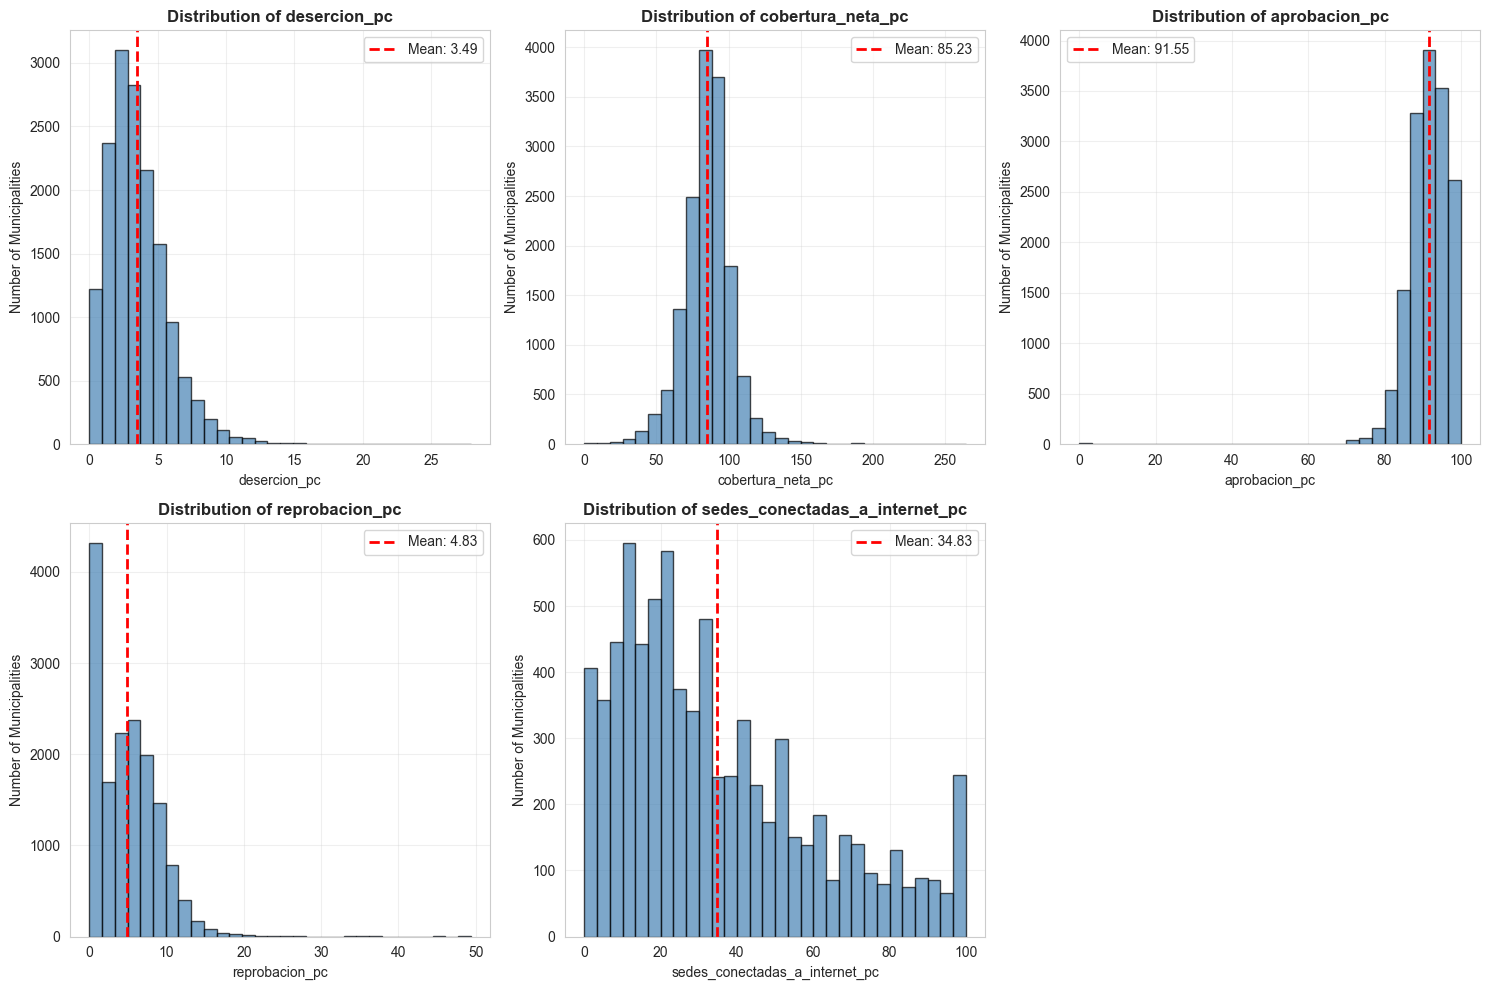


💡 What to Look For:
   • Normal distribution (bell curve): Most values in the middle
   • Skewed: Values bunched to one side
   • Bimodal: Two peaks (two distinct groups?)
   • Outliers: Isolated values far from the rest


In [12]:
if df is not None and 'available_metrics' in locals() and available_metrics:
    # Create histograms
    n_metrics = len(available_metrics)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, metric in enumerate(available_metrics):
        if idx < len(axes):
            data = df[metric].dropna()
            
            axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
            axes[idx].axvline(data.mean(), color='red', linestyle='--', 
                            linewidth=2, label=f'Mean: {data.mean():.2f}')
            axes[idx].set_title(f'Distribution of {metric}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel(metric)
            axes[idx].set_ylabel('Number of Municipalities')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(available_metrics), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 What to Look For:")
    print("   • Normal distribution (bell curve): Most values in the middle")
    print("   • Skewed: Values bunched to one side")
    print("   • Bimodal: Two peaks (two distinct groups?)")
    print("   • Outliers: Isolated values far from the rest")
else:
    print("⚠️  Skipping visualization - no data available")

### Correlation Analysis

**What is Correlation?**

Correlation measures if two things move together:
- **Positive correlation (+1)**: When one goes up, the other goes up
  - Example: "More ice cream sales = hotter weather"
- **Negative correlation (-1)**: When one goes up, the other goes down
  - Example: "More study time = fewer failures"
- **No correlation (0)**: No relationship
  - Example: "Shoe size ≠ math scores"

**Important**: Correlation ≠ Causation!
- Just because two things correlate doesn't mean one causes the other
- Example: Ice cream sales and drownings correlate (both happen in summer), but ice cream doesn't cause drowning!

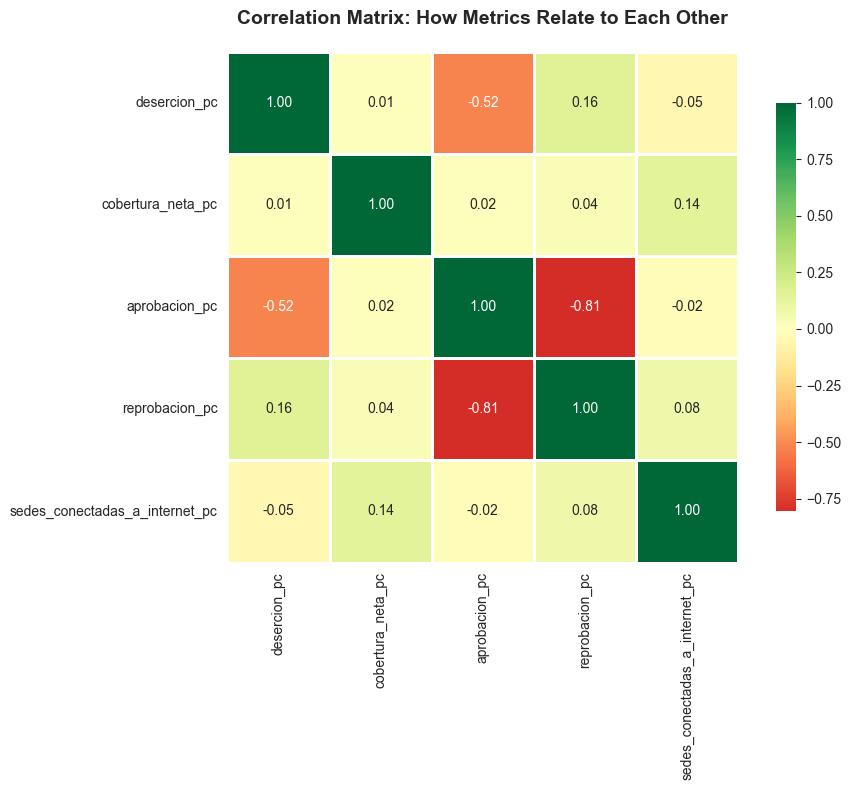


🎨 Reading the Heatmap:
   • 🟢 Green: Positive correlation (both increase together)
   • 🔴 Red: Negative correlation (one increases, other decreases)
   • 🟡 Yellow: Weak or no correlation

💡 Look for:
   • Strong positive: What factors support student success?
   • Strong negative: What factors prevent dropout?
   • Unexpected patterns: Surprises that need investigation


In [13]:
if df is not None and 'available_metrics' in locals() and len(available_metrics) > 1:
    # Calculate correlation matrix
    correlation_matrix = df[available_metrics].corr()
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, 
                annot=True,  # Show correlation values
                fmt='.2f',   # 2 decimal places
                cmap='RdYlGn',  # Red-Yellow-Green color scheme
                center=0,    # Center colormap at 0
                square=True,
                linewidths=1,
                cbar_kws={"shrink": 0.8})
    
    plt.title('Correlation Matrix: How Metrics Relate to Each Other', 
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n🎨 Reading the Heatmap:")
    print("   • 🟢 Green: Positive correlation (both increase together)")
    print("   • 🔴 Red: Negative correlation (one increases, other decreases)")
    print("   • 🟡 Yellow: Weak or no correlation")
    print("\n💡 Look for:")
    print("   • Strong positive: What factors support student success?")
    print("   • Strong negative: What factors prevent dropout?")
    print("   • Unexpected patterns: Surprises that need investigation")
else:
    print("⚠️  Skipping correlation analysis - insufficient data")

---

<a id='random-forest'></a>
## 4. Dropout Prediction with Random Forest

### 🎯 Our Goal

**Predict which municipalities will have high dropout rates** so we can intervene early!

### What is Random Forest?

Imagine you want to predict if a student will succeed. You could ask:
- **Teacher A**: Looks only at test scores
- **Teacher B**: Looks only at attendance
- **Teacher C**: Looks only at participation

Each teacher gives a prediction. **Random Forest** does exactly this:
1. Creates many "decision trees" (like teachers)
2. Each tree looks at the data slightly differently
3. Combines all predictions (like taking a vote)
4. Final prediction = majority vote

### Why Random Forest?

✅ **Advantages**:
- Works well with multiple factors (coverage, poverty, internet, etc.)
- Handles missing data gracefully
- Tells us which factors are most important
- Doesn't easily "overfit" (memorize instead of learn)
- Very accurate in practice

❌ **Limitations**:
- Can be slow with huge datasets
- Harder to explain than simple models
- Needs more memory

### Key Concepts

**Features** (X): The information we use to make predictions
- Example: Coverage rate, approval rate, internet access

**Target** (Y): What we want to predict
- Example: Dropout rate

**Training**: Teaching the model by showing it examples
**Testing**: Checking if the model learned correctly

### Preparing Data for Random Forest

**What we're doing**:
1. Select **features** (what we know) to predict **target** (dropout rate)
2. Filter for rows with complete data (PAL requires no missing values)
3. Create a view in HANA with just the columns we need

In [14]:
if hana_data is not None and df is not None:
    print("🔧 Preparing data for Random Forest...\n")
    
    # Define features and target
    feature_cols = [
        'cobertura_neta_pc',
        'aprobacion_pc',
        'reprobacion_pc',
        'sedes_conectadas_a_internet_pc',
        'poblacion_5_16_int'
    ]
    
    target_col = 'desercion_pc'
    id_col = 'codigo_municipio'
    
    # Filter columns that exist
    available_features = [col for col in feature_cols if col in df.columns]
    
    if target_col in df.columns and available_features:
        # Select needed columns from HANA data
        model_cols = [id_col] + available_features + [target_col]
        model_cols = [c for c in model_cols if c in hana_data.columns]
        
        # Create filtered view (removes rows with missing values)
        hana_model_data = hana_data.select(model_cols).dropna()
        
        print(f"📊 Model dataset prepared:")
        print(f"   Shape: {hana_model_data.shape}")
        print(f"\n📝 Features (predictors):")
        for feat in available_features:
            print(f"   • {feat}")
        print(f"\n🎯 Target (what we predict): {target_col}")
        
        # Show sample
        print(f"\n👀 Sample of model data:")
        display(hana_model_data.head(5).collect())
        
    else:
        print("❌ Required columns not found in dataset")
        hana_model_data = None
        available_features = []
else:
    print("⚠️  No data available")
    hana_model_data = None
    available_features = []

🔧 Preparing data for Random Forest...

📊 Model dataset prepared:
   Shape: [7516, 7]

📝 Features (predictors):
   • cobertura_neta_pc
   • aprobacion_pc
   • reprobacion_pc
   • sedes_conectadas_a_internet_pc
   • poblacion_5_16_int

🎯 Target (what we predict): desercion_pc

👀 Sample of model data:


,codigo_municipio,cobertura_neta_pc,aprobacion_pc,reprobacion_pc,sedes_conectadas_a_internet_pc,poblacion_5_16_int,desercion_pc
0,95200,25.69,98.39,0.00,15.00,3301.0,1.61
1,94883,49.92,97.01,0.27,20.00,589.0,2.72
2,94663,27.00,71.13,20.42,100.00,800.0,8.45
3,05021,104.59,92.95,3.69,14.29,566.0,3.37
4,05044,68.87,91.20,4.56,17.65,1722.0,4.24


### Training the Random Forest Model

**What's happening**:
1. PAL creates multiple decision trees (100 by default)
2. Each tree learns patterns from the training data
3. The model combines all trees to make predictions

**Key Parameters**:
- `n_estimators`: Number of trees (more = more accurate but slower)
- `random_state`: Seed for reproducibility (same results each run)
- `thread_ratio`: How much of HANA's CPU to use (0.5 = 50%)

**Note**: The model training happens **inside HANA**, not in Python! We're just sending instructions.

In [22]:
if hana_model_data is not None and available_features:
    try:
        print("🌲 Training Random Forest model in HANA...\n")
        
        # Create Random Forest Regressor
        rf_model = UnifiedRegression(
            func='RandomDecisionTree',
            n_estimators=100,  # Number of trees
            random_state=42,   # For reproducibility
            thread_ratio=0.5   # Use 50% of HANA CPU
        )
        
        # Train the model
        rf_model.fit(
            data=hana_model_data,
            key=id_col,
            features=available_features,
            label=target_col
        )
        
        print("✅ Model trained successfully!\n")
        
        # Get feature importance
        print("📊 Feature Importance (What Matters Most):")
        print("=" * 60)
        
        importance_dict = rf_model.get_feature_importances()  # Returns a dict!
        
        if importance_dict is not None and isinstance(importance_dict, dict):
            # Convert dict to DataFrame
            import pandas as pd
            importance_df = pd.DataFrame([
                {'FEATURE_NAME': feature, 'IMPORTANCE': importance}
                for feature, importance in importance_dict.items()
            ])
            importance_df = importance_df.sort_values(
                by='IMPORTANCE', ascending=False
            )
            display(importance_df)
            
            print("\n💡 How to Read Feature Importance:")
            print("   • Higher value = more important for predictions")
            print("   • Top features have the biggest impact on dropout")
            print("   • Focus interventions on improving top features")
        else:
            print("⚠️  Feature importance not available")
        
    except Exception as e:
        print(f"❌ Model training failed: {e}")
        print("\nPossible issues:")
        print("  1. PAL not enabled - check with your admin")
        print("  2. Insufficient privileges - need AFL__SYS_AFL_AFLPAL_EXECUTE")
        print("  3. Data type mismatches - check column types")
        rf_model = None
else:
    print("⚠️  Skipping model training - no data available")
    rf_model = None


🌲 Training Random Forest model in HANA...

✅ Model trained successfully!

📊 Feature Importance (What Matters Most):


,FEATURE_NAME,IMPORTANCE
1,aprobacion_pc,0.605079
2,reprobacion_pc,0.211091
4,poblacion_5_16_int,0.085341
0,cobertura_neta_pc,0.050163
3,sedes_conectadas_a_internet_pc,0.048325



💡 How to Read Feature Importance:
   • Higher value = more important for predictions
   • Top features have the biggest impact on dropout
   • Focus interventions on improving top features


### Making Predictions

Now let's use our trained model to predict dropout rates!

**What we get**:
- Predicted dropout rate for each municipality
- Comparison with actual dropout rate
- Error (difference between prediction and reality)

🔮 Making predictions...

✅ Predictions complete!

📊 Top 10 Predictions vs Actual:


,codigo_municipio,Actual_Dropout,Predicted_Dropout,Error,Error_Pct
0,95200,1.61,1.76754,0.15754,9.79
1,95200,1.61,2.65263,1.04263,64.76
2,95200,1.61,4.29776,2.68776,166.94
3,95200,1.61,5.09106,3.48106,216.21
4,95200,1.61,4.12733,2.51733,156.36
5,94883,2.72,2.39401,0.32599,11.98
6,94883,2.72,4.21199,1.49199,54.85
7,94883,2.72,2.58477,0.13523,4.97
8,94883,2.72,2.94329,0.22329,8.21
9,94663,8.45,5.51768,2.93232,34.70



📈 Model Performance:
   Average Error: 1.41 percentage points
   Median Error: 1.05 percentage points
   This means our predictions are typically off by 1.41%


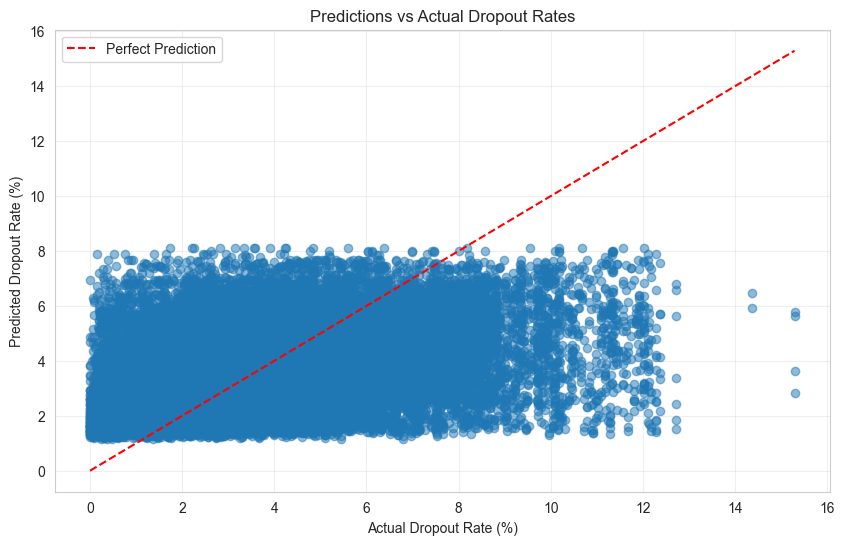


💡 Reading the Chart:
   • Points on red line = perfect predictions
   • Points above line = model overestimated
   • Points below line = model underestimated
   • Closer to line = better predictions


In [23]:
if rf_model is not None:
    try:
        print("🔮 Making predictions...\n")
        
        # Predict
        predictions = rf_model.predict(
            data=hana_model_data,
            key=id_col
        )
        
        # Get results
        pred_results = predictions.collect()
        
        # Get original data
        original_data = hana_model_data.collect()
        
        # Merge for comparison
        if id_col in original_data.columns and id_col in pred_results.columns:
            # Select columns for comparison
            compare_cols = [id_col, target_col]
            if 'municipio' in original_data.columns:
                compare_cols.insert(1, 'municipio')
            
            comparison = original_data[compare_cols].merge(
                pred_results[[id_col, 'SCORE']],
                on=id_col,
                how='inner'
            )
            
            # Rename for clarity
            comparison = comparison.rename(columns={
                target_col: 'Actual_Dropout',
                'SCORE': 'Predicted_Dropout'
            })
            
            comparison['Error'] = abs(comparison['Actual_Dropout'] - comparison['Predicted_Dropout'])
            comparison['Error_Pct'] = (comparison['Error'] / comparison['Actual_Dropout'] * 100).round(2)
            
            print("✅ Predictions complete!\n")
            print("📊 Top 10 Predictions vs Actual:")
            display(comparison.head(10))
            
            # Calculate metrics
            mean_error = comparison['Error'].mean()
            median_error = comparison['Error'].median()
            print(f"\n📈 Model Performance:")
            print(f"   Average Error: {mean_error:.2f} percentage points")
            print(f"   Median Error: {median_error:.2f} percentage points")
            print(f"   This means our predictions are typically off by {mean_error:.2f}%")
            
            # Visualize predictions vs actual
            plt.figure(figsize=(10, 6))
            plt.scatter(comparison['Actual_Dropout'], 
                       comparison['Predicted_Dropout'],
                       alpha=0.5)
            plt.plot([0, comparison['Actual_Dropout'].max()], 
                    [0, comparison['Actual_Dropout'].max()], 
                    'r--', label='Perfect Prediction')
            plt.xlabel('Actual Dropout Rate (%)')
            plt.ylabel('Predicted Dropout Rate (%)')
            plt.title('Predictions vs Actual Dropout Rates')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            print("\n💡 Reading the Chart:")
            print("   • Points on red line = perfect predictions")
            print("   • Points above line = model overestimated")
            print("   • Points below line = model underestimated")
            print("   • Closer to line = better predictions")
            
    except Exception as e:
        print(f"❌ Prediction failed: {e}")
else:
    print("⚠️  No model available for predictions")

### 🎯 Key Takeaways from Dropout Prediction

**What did we learn?**

1. **Feature Importance** tells us which factors most influence dropout:
   - Focus improvement efforts on the top factors
   - Lower-importance factors may not be worth heavy investment

2. **Prediction Accuracy** shows how reliable our forecasts are:
   - Lower error = more trustworthy predictions
   - Can use predictions to prioritize which municipalities need help

3. **Actionable Insights**:
   - Identify high-risk municipalities before dropout happens
   - Allocate resources to areas predicted to have problems
   - Monitor if interventions improve predicted outcomes

**Real-World Application**:
- Government can use this to plan budgets
- Schools can request support based on predictions
- Track progress: Are interventions working?

---

<a id='kmeans'></a>
## 5. Municipality Clustering with K-Means

### 📊 Our Goal

**Group similar municipalities together** so we can create targeted policies for each group!

### What is Clustering?

Imagine you're organizing your closet:
- **Cluster 1**: Formal clothes (suits, dresses)
- **Cluster 2**: Casual clothes (jeans, t-shirts)
- **Cluster 3**: Sports clothes (gym wear)

Clustering does this automatically with data! It finds natural groups without you telling it what the groups should be.

### What is K-Means?

K-Means is like organizing people into groups for team sports:

1. **Pick K team captains** (K = number of clusters)
2. **Each person joins nearest captain** (based on similarity)
3. **Captains move to center** of their team
4. **Repeat** until teams stabilize

In our case:
- "People" = municipalities
- "Similarity" = educational metrics
- "Teams" = clusters

### Why Cluster Municipalities?

✅ **Advantages**:
- Discover natural groupings in data
- Create targeted policies for each cluster
- Identify similar municipalities that can share best practices
- Simplify complex data into manageable groups

❌ **Limitations**:
- Need to choose K (number of clusters) in advance
- Sensitive to outliers
- Assumes spherical clusters

### Business Value

**Example clusters we might find**:
- 🟢 "High performers": Good metrics across the board
- 🟡 "Improving": Some strengths, some weaknesses
- 🔴 "Need support": Low metrics, require intervention
- 🟦 "Urban/Rural divide": Different challenges, need different solutions

### Preparing Data for Clustering

**Important**: For clustering, we need to **normalize** the data!

**Why normalize?**
- Different features have different scales
- Example: Population (thousands) vs Dropout rate (0-100)
- Without normalization, large values dominate

**Normalization** puts all features on the same scale (typically 0-1)

**Good news**: K-Means in PAL has built-in normalization! We just need to enable it.

In [24]:
if hana_data is not None and df is not None:
    print("🔧 Preparing data for clustering...\n")
    
    # Select features for clustering
    cluster_features = [
        'cobertura_neta_pc',
        'desercion_pc',
        'aprobacion_pc',
        'sedes_conectadas_a_internet_pc'
    ]
    
    # Filter available features
    available_cluster_features = [col for col in cluster_features if col in df.columns]
    
    if available_cluster_features and id_col in df.columns:
        # Prepare clustering dataset from HANA
        cluster_cols = [id_col] + available_cluster_features
        if 'municipio' in hana_data.columns:
            cluster_cols.append('municipio')
        
        cluster_cols = [c for c in cluster_cols if c in hana_data.columns]
        hana_cluster_data = hana_data.select(cluster_cols).dropna()
        
        print(f"📊 Clustering dataset prepared:")
        print(f"   Shape: {hana_cluster_data.shape}")
        print(f"   Features for clustering:")
        for feat in available_cluster_features:
            print(f"   • {feat}")
        
        print("\n👀 Sample:")
        display(hana_cluster_data.head(5).collect())
        
    else:
        print("❌ Required columns not found")
        hana_cluster_data = None
        available_cluster_features = []
else:
    print("⚠️  No data available")
    hana_cluster_data = None
    available_cluster_features = []

🔧 Preparing data for clustering...

📊 Clustering dataset prepared:
   Shape: [7572, 6]
   Features for clustering:
   • cobertura_neta_pc
   • desercion_pc
   • aprobacion_pc
   • sedes_conectadas_a_internet_pc

👀 Sample:


,codigo_municipio,cobertura_neta_pc,desercion_pc,aprobacion_pc,sedes_conectadas_a_internet_pc,municipio
0,95200,25.69,1.61,98.39,15.00,Miraflores
1,94883,49.92,2.72,97.01,20.00,San Felipe
2,94663,27.00,8.45,71.13,100.00,Mapiripana
3,05021,104.59,3.37,92.95,14.29,Alejandría
4,05044,68.87,4.24,91.20,17.65,Anza


### Choosing the Number of Clusters (K)

**The Big Question**: How many clusters should we create?

**Methods to decide**:
1. **Elbow Method**: Plot K vs error, look for "elbow" (bend in curve)
2. **Business Knowledge**: Based on what makes sense for policy
3. **Trial and Error**: Try different K values, see what's interpretable

**For education data**, good starting points:
- K=3: Low/Medium/High performers
- K=4: Add Urban/Rural dimension
- K=5: More nuanced groupings

Let's start with **K=4** as a reasonable middle ground.

In [27]:
if hana_cluster_data is not None and available_cluster_features:
    try:
        print("🎯 Running K-Means clustering in HANA...\n")
        
        # Create K-Means model
        n_clusters = 4
        kmeans = clustering.KMeans(
            n_clusters=n_clusters,
            init='first_k',  # Random initialization
            max_iter=100,   # Maximum iterations
            thread_ratio=0.5,
            distance_level='Euclidean',  # How to measure distance
            normalization='min_max'  # Normalize data automatically
        )
        
        # Fit and predict
        kmeans.fit_predict(
            data=hana_cluster_data,
            key=id_col,
            features=available_cluster_features
        )
        
        print(f"✅ K-Means clustering complete!")
        print(f"   Number of clusters: {n_clusters}\n")
        
        # Get cluster assignments
        labels = kmeans.labels_.collect()
        
        # Get cluster centers
        centers = kmeans.cluster_centers_.collect()
        
        print("📊 Cluster Centers (Average values for each cluster):")
        print("=" * 80)
        display(centers)
        
        print("\n💡 How to Read Cluster Centers:")
        print("   • Each row = one cluster")
        print("   • Numbers show average feature values for municipalities in that cluster")
        print("   • Compare clusters to see what makes them different")
        
    except Exception as e:
        print(f"❌ Clustering failed: {e}")
        print("\nPossible issues:")
        print("  1. PAL not enabled")
        print("  2. Insufficient privileges")
        print("  3. Data issues")
        labels = None
        centers = None
else:
    print("⚠️  No data available for clustering")
    labels = None
    centers = None

🎯 Running K-Means clustering in HANA...

✅ K-Means clustering complete!
   Number of clusters: 4

📊 Cluster Centers (Average values for each cluster):


,CLUSTER_ID,cobertura_neta_pc,desercion_pc,aprobacion_pc,sedes_conectadas_a_internet_pc
0,0,0.268808,0.160350,0.872262,0.145828
1,1,0.281579,0.188596,0.842038,0.442986
2,2,0.296832,0.228553,0.801844,0.815950
3,3,0.277131,0.410892,0.694272,0.208173



💡 How to Read Cluster Centers:
   • Each row = one cluster
   • Numbers show average feature values for municipalities in that cluster
   • Compare clusters to see what makes them different


### Analyzing Cluster Results

Let's merge cluster assignments with our original data to understand what each cluster represents.

📊 Cluster Distribution:
   Cluster 0: 18490 municipalities (35.7%)
   Cluster 1: 14036 municipalities (27.1%)
   Cluster 2: 8773 municipalities (16.9%)
   Cluster 3: 10559 municipalities (20.4%)

📈 Cluster Characteristics:

🔷 CLUSTER 0:
   Size: 18490 municipalities
   • cobertura_neta_pc: 82.97
   • desercion_pc: 3.02
   • aprobacion_pc: 94.02
   • sedes_conectadas_a_internet_pc: 23.41
   Examples: Miraflores, Miraflores, Miraflores

🔷 CLUSTER 1:
   Size: 14036 municipalities
   • cobertura_neta_pc: 86.07
   • desercion_pc: 3.24
   • aprobacion_pc: 93.43
   • sedes_conectadas_a_internet_pc: 38.86
   Examples: Mapiripana, Mapiripana, Alejandría

🔷 CLUSTER 2:
   Size: 8773 municipalities
   • cobertura_neta_pc: 89.13
   • desercion_pc: 3.46
   • aprobacion_pc: 92.45
   • sedes_conectadas_a_internet_pc: 63.55
   Examples: Mapiripana, Mapiripana, Mapiripana

🔷 CLUSTER 3:
   Size: 10559 municipalities
   • cobertura_neta_pc: 85.11
   • desercion_pc: 4.84
   • aprobacion_pc: 90.24
   • sede

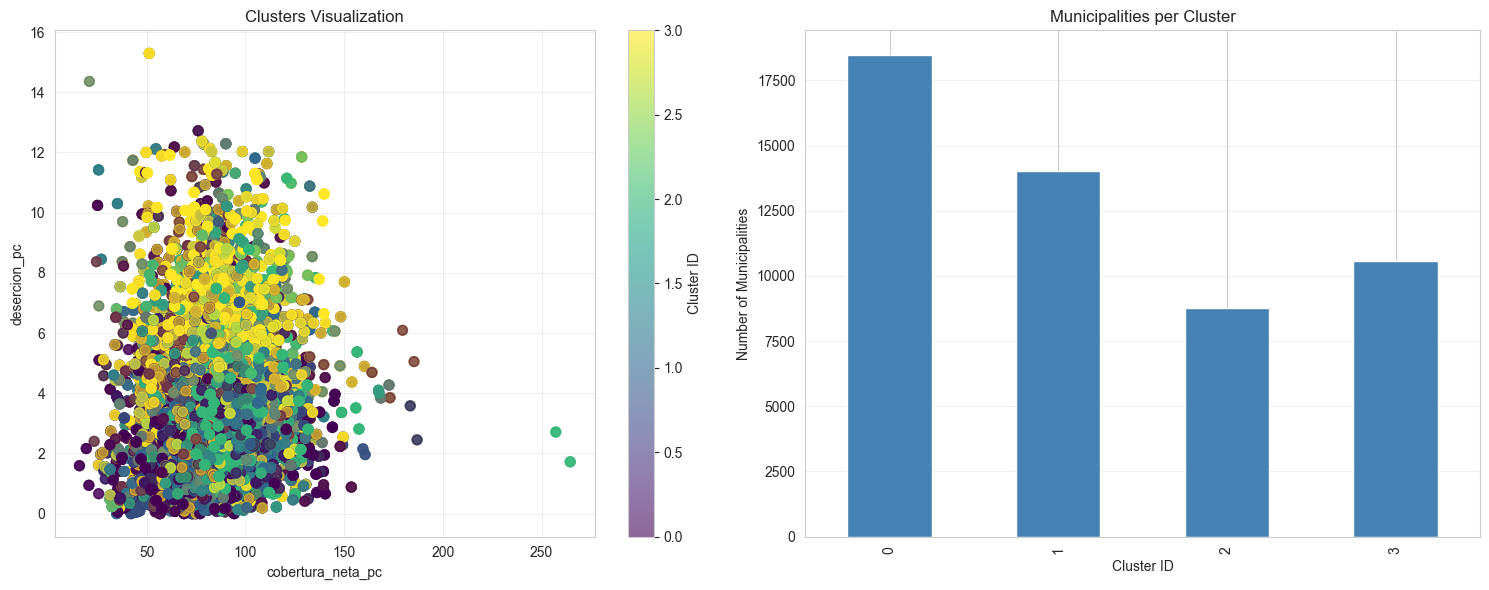


💡 Reading the Visualizations:
   Left plot: Each point is a municipality, color = cluster
   Right plot: How many municipalities in each cluster
   Look for: Are clusters well-separated or overlapping?


In [28]:
if labels is not None and hana_cluster_data is not None:
    # Get cluster data as pandas
    df_cluster = hana_cluster_data.collect()
    
    # Merge cluster labels with original data
    cluster_results = df_cluster.merge(
        labels[[id_col, 'CLUSTER_ID']],
        on=id_col,
        how='inner'
    )
    
    print("📊 Cluster Distribution:")
    print("=" * 60)
    cluster_counts = cluster_results['CLUSTER_ID'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        pct = (count / len(cluster_results) * 100)
        print(f"   Cluster {cluster_id}: {count} municipalities ({pct:.1f}%)")
    
    # Show characteristics of each cluster
    print("\n📈 Cluster Characteristics:")
    print("=" * 80)
    
    for cluster_id in sorted(cluster_results['CLUSTER_ID'].unique()):
        cluster_data = cluster_results[cluster_results['CLUSTER_ID'] == cluster_id]
        
        print(f"\n🔷 CLUSTER {cluster_id}:")
        print(f"   Size: {len(cluster_data)} municipalities")
        
        for feat in available_cluster_features:
            mean_val = cluster_data[feat].mean()
            print(f"   • {feat}: {mean_val:.2f}")
        
        # Show sample municipalities
        if 'municipio' in cluster_data.columns:
            sample_munis = cluster_data['municipio'].head(3).tolist()
            print(f"   Examples: {', '.join(sample_munis)}")
    
    # Visualize clusters
    print("\n📊 Visualizing Clusters...")
    
    if len(available_cluster_features) >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: First two features
        scatter = axes[0].scatter(
            cluster_results[available_cluster_features[0]],
            cluster_results[available_cluster_features[1]],
            c=cluster_results['CLUSTER_ID'],
            cmap='viridis',
            alpha=0.6,
            s=50
        )
        axes[0].set_xlabel(available_cluster_features[0])
        axes[0].set_ylabel(available_cluster_features[1])
        axes[0].set_title('Clusters Visualization')
        axes[0].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0], label='Cluster ID')
        
        # Plot 2: Cluster sizes
        cluster_counts.plot(kind='bar', ax=axes[1], color='steelblue')
        axes[1].set_xlabel('Cluster ID')
        axes[1].set_ylabel('Number of Municipalities')
        axes[1].set_title('Municipalities per Cluster')
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        print("\n💡 Reading the Visualizations:")
        print("   Left plot: Each point is a municipality, color = cluster")
        print("   Right plot: How many municipalities in each cluster")
        print("   Look for: Are clusters well-separated or overlapping?")

else:
    print("⚠️  No cluster results to analyze")

### 🎯 Key Takeaways from Clustering

**What did we learn?**

1. **Natural Groups Exist**: Municipalities aren't all the same - they form distinct groups

2. **Cluster Profiles**: Each cluster has unique characteristics:
   - Which metrics are high/low?
   - What challenges does each face?
   - What interventions make sense?

3. **Actionable Insights**:
   - Design policies targeted at each cluster
   - Municipalities in same cluster can share best practices
   - Budget allocation based on cluster needs

**Example Use Cases**:
- **Cluster 0** (High performers): Share best practices, maintain excellence
- **Cluster 1** (Average): Identify what's holding them back from top tier
- **Cluster 2** (Need support): Heavy intervention, resource allocation
- **Cluster 3** (Specific issues): Targeted programs for specific problems

**Policy Implications**:
- One-size-fits-all doesn't work
- Each cluster needs different strategies
- Monitor cluster migration (are municipalities improving?)

---

<a id='anomaly'></a>
## 6. Anomaly Detection with Isolation Forest

### 🔍 Our Goal

**Find municipalities with unusual patterns** that might indicate:
- Data quality issues (errors in reporting)
- Special circumstances (disasters, unique programs)
- Fraud or manipulation
- Exceptional success stories

### What is Anomaly Detection?

Imagine a classroom of students:
- Most score between 60-90
- One student scores 10 → **Anomaly** (might need help)
- One student scores 100 → **Anomaly** (exceptionally good)
- One student scores 250 → **Anomaly** (probably an error!)

Anomaly detection finds data points that don't fit the normal pattern.

### What is Isolation Forest?

Think of it like trying to isolate someone at a party:
- **Normal people**: Hard to isolate (they're in the crowd)
- **Unusual people**: Easy to isolate (they're standing apart)

Isolation Forest works by:
1. Randomly partitioning the data
2. Anomalies get isolated quickly (few partitions needed)
3. Normal points need many partitions to isolate

### Why Use It?

✅ **Advantages**:
- Fast and efficient
- Works well with high-dimensional data
- Doesn't require labeled anomalies for training
- Good at finding outliers of all types

❌ **Limitations**:
- Can be sensitive to parameter settings
- Might flag legitimate edge cases
- Needs manual investigation of flagged points

### Business Value

**Why care about anomalies?**
- **Data Quality**: Fix reporting errors
- **Special Cases**: Understand why some municipalities are different
- **Learning Opportunities**: Study exceptional successes
- **Risk Management**: Identify potential problems early

### 📝 Note:
PAL may not have Isolation Forest, so we'll use scikit-learn locally. This means we bring the data to Python for this analysis.

In [ ]:
if hana_cluster_data is not None and available_cluster_features:
    try:
        print("🌲 Running Isolation Forest for anomaly detection...\n")
        
        # Import scikit-learn's Isolation Forest
        from sklearn.ensemble import IsolationForest as SKLearnIsolationForest
        
        # Get data as pandas
        df_cluster = hana_cluster_data.collect()
        
        # Prepare feature matrix
        X = df_cluster[available_cluster_features].values
        
        # Create and fit model
        iso_forest = SKLearnIsolationForest(
            contamination=0.05,  # Expect 5% anomalies
            random_state=42,
            n_estimators=100
        )
        
        # Predict (-1 = anomaly, 1 = normal)
        predictions = iso_forest.fit_predict(X)
        
        # Get anomaly scores (lower = more anomalous)
        scores = iso_forest.score_samples(X)
        
        # Add results to dataframe
        df_cluster['anomaly'] = predictions
        df_cluster['anomaly_score'] = scores
        df_cluster['is_anomaly'] = predictions == -1
        
        # Count anomalies
        n_anomalies = (predictions == -1).sum()
        pct_anomalies = (n_anomalies / len(predictions) * 100)
        
        print(f"✅ Anomaly detection complete!\n")
        print(f"📊 Results:")
        print(f"   Total municipalities: {len(predictions)}")
        print(f"   Normal: {(predictions == 1).sum()}")
        print(f"   Anomalies detected: {n_anomalies} ({pct_anomalies:.1f}%)")
        
        # Show most anomalous municipalities
        print("\n🔴 Top 10 Most Anomalous Municipalities:")
        print("=" * 80)
        
        anomalies = df_cluster[df_cluster['is_anomaly']].copy()
        anomalies = anomalies.sort_values('anomaly_score')
        
        display_cols = [id_col] + (['municipio'] if 'municipio' in anomalies.columns else []) + \
                      available_cluster_features + ['anomaly_score']
        display(anomalies[display_cols].head(10))
        
        print("\n💡 How to Read Anomaly Scores:")
        print("   • Lower score = more anomalous")
        print("   • Negative scores = definitely anomalous")
        print("   • Check these municipalities for:")
        print("     - Data entry errors")
        print("     - Special circumstances")
        print("     - Exceptional cases worth studying")
        
        anomaly_results = df_cluster
        
    except ImportError:
        print("❌ scikit-learn not available for anomaly detection")
        print("   Install with: pip install scikit-learn")
        anomaly_results = None
    except Exception as e:
        print(f"❌ Anomaly detection failed: {e}")
        anomaly_results = None
else:
    print("⚠️  Skipping anomaly detection - no data available")
    anomaly_results = None

### Visualizing Anomalies

Let's visualize where anomalies appear in our data.

In [ ]:
if 'anomaly_results' in locals() and anomaly_results is not None and len(available_cluster_features) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Anomalies highlighted
    normal = anomaly_results[~anomaly_results['is_anomaly']]
    anomalies = anomaly_results[anomaly_results['is_anomaly']]
    
    axes[0].scatter(
        normal[available_cluster_features[0]],
        normal[available_cluster_features[1]],
        c='blue', alpha=0.5, s=30, label='Normal'
    )
    axes[0].scatter(
        anomalies[available_cluster_features[0]],
        anomalies[available_cluster_features[1]],
        c='red', alpha=0.8, s=100, marker='X', label='Anomaly'
    )
    axes[0].set_xlabel(available_cluster_features[0])
    axes[0].set_ylabel(available_cluster_features[1])
    axes[0].set_title('Anomaly Detection Results')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Anomaly score distribution
    axes[1].hist(anomaly_results['anomaly_score'], bins=50, 
                edgecolor='black', alpha=0.7, color='steelblue')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, 
                   label='Anomaly Threshold')
    axes[1].set_xlabel('Anomaly Score')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Anomaly Scores')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Reading the Charts:")
    print("   Left: Red X markers are anomalies - do they make sense?")
    print("   Right: Most scores should be near zero; far left = anomalies")
else:
    print("⚠️  Skipping visualization - no anomaly results")

### 🎯 Key Takeaways from Anomaly Detection

**What did we learn?**

1. **Not All Anomalies Are Bad**:
   - Some may be data errors (need fixing)
   - Some may be exceptional success (learn from them!)
   - Some may be unique circumstances (context matters)

2. **Investigation Needed**:
   - Each anomaly should be manually reviewed
   - Ask: "Why is this municipality different?"
   - Determine: Error, special case, or legitimate outlier?

3. **Actionable Insights**:
   - **Data Quality**: Fix errors in next data collection
   - **Best Practices**: Study positive anomalies
   - **Risk Management**: Investigate negative anomalies

**Next Steps**:
1. Review top 10 anomalies manually
2. Contact municipalities for clarification
3. Document reasons for anomalies
4. Improve data collection to reduce errors

---

<a id='insights'></a>
## 7. 💡 Insights & Recommendations

### Summary of All Analyses

Let's bring together everything we learned:

#### 🎯 From Dropout Prediction (Random Forest):
- **What matters most**: Feature importance shows which factors drive dropout
- **Who needs help**: Predicted high-risk municipalities
- **How accurate**: Model performance metrics

#### 📊 From Municipality Clustering (K-Means):
- **Natural groups exist**: Municipalities fall into distinct clusters
- **Different needs**: Each cluster requires different interventions
- **Policy targeting**: One-size-fits-all doesn't work

#### 🔍 From Anomaly Detection (Isolation Forest):
- **Outliers identified**: Unusual municipalities flagged
- **Data quality**: Some anomalies may be errors
- **Special cases**: Some anomalies are legitimate and interesting

### Bringing It All Together

**A Complete Picture**:
1. Use **clustering** to group similar municipalities
2. Use **prediction** to identify at-risk municipalities
3. Use **anomaly detection** to find special cases
4. Combine insights for comprehensive policy

### Real-World Applications

**For Government Officials**:
- Budget allocation based on cluster needs
- Early intervention for predicted high-risk areas
- Investigate anomalies for lessons learned

**For School Districts**:
- Compare performance to similar municipalities (same cluster)
- Learn from successful municipalities in your cluster
- Request resources if predicted to struggle

**For Researchers**:
- Study what makes top performers successful
- Analyze cluster characteristics
- Investigate anomalies for deeper understanding

### Limitations to Keep in Mind

⚠️ **Remember**:
- Models are tools, not crystal balls
- Predictions can be wrong - use as guides, not absolutes
- Context matters - numbers don't tell whole story
- Correlation ≠ Causation
- Data quality affects results

### Next Steps for Deeper Analysis

**To improve this analysis**:
1. **Add more features**:
   - Socioeconomic data
   - Geographic information
   - Historical trends

2. **Try other algorithms**:
   - Gradient Boosting (more accurate predictions)
   - DBSCAN (density-based clustering)
   - Time series analysis (trends over time)

3. **Validation**:
   - Test predictions against next year's data
   - Cross-validation for reliability
   - A/B testing of interventions

4. **Automation**:
   - Regular model updates
   - Automated reporting
   - Real-time monitoring

### Final Thoughts

**Machine Learning is a Tool, Not Magic**

The models we built are helpers in decision-making:
- They find patterns humans might miss
- They process large amounts of data quickly
- They provide objective, data-driven insights

But:
- They need human judgment to interpret
- They require domain expertise to apply
- They work best when combined with local knowledge

**The Real Power**: Combining ML insights with human expertise!

### 🎓 Congratulations!

You've completed a full machine learning pipeline:
1. ✅ Connected to SAP HANA Cloud
2. ✅ Loaded existing data from HANA
3. ✅ Explored data patterns
4. ✅ Built predictive models
5. ✅ Performed clustering analysis
6. ✅ Detected anomalies
7. ✅ Generated actionable insights

You now have the foundation to apply ML to real-world education challenges!

### 📚 Further Learning Resources

**To deepen your ML knowledge**:
- SAP HANA PAL Documentation
- Scikit-learn tutorials
- Online ML courses (Coursera, edX)
- Books: "Introduction to Machine Learning with Python"
- Practice with more datasets!

### 📝 Questions to Reflect On

1. Which findings surprised you most?
2. What would you want to investigate further?
3. How would you present these insights to stakeholders?
4. What additional data would help improve the models?
5. What interventions would you recommend for each cluster?

---

**Thank you for following along this educational journey! 🎉**

## 🔗 References

- [SAP HANA PAL Documentation](https://help.sap.com/viewer/319d36de4fd64ac3afbf91b1fb3ce8de/latest/en-US)
- [hana-ml Python Package](https://pypi.org/project/hana-ml/)
- [Random Forest Algorithm](https://en.wikipedia.org/wiki/Random_forest)
- [K-Means Clustering](https://en.wikipedia.org/wiki/K-means_clustering)
- [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest)